# Forest Fire Mini Project 

> in this file, you can find analysis for this project. For the final report please visit `Report.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE

from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Introduction


### Data Information

The Forest Fires data is available at UCI, to reach it please click [here](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

The citation to this data set: 

[Cortez and Morais, 2007] P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. Available at: [http://www.dsi.uminho.pt/~pcortez/fires.pdf](http://www3.dsi.uminho.pt/pcortez/fires.pdf)
    
#### Attributes:

1. `X` - x-axis spatial coordinate within the Montesinho park map: 1 to 9 
2. `Y` - y-axis spatial coordinate within the Montesinho park map: 2 to 9 
3. `month` - month of the year: 'jan' to 'dec' 
4. `day` - day of the week: 'mon' to 'sun' 
5. `FFMC` - FFMC index from the FWI system: 18.7 to 96.20 
6. `DMC` - DMC index from the FWI system: 1.1 to 291.3 
7. `DC` - DC index from the FWI system: 7.9 to 860.6 
8. `ISI` - ISI index from the FWI system: 0.0 to 56.10 
9. `temp` - temperature in Celsius degrees: 2.2 to 33.30 
10. `RH` - relative humidity in %: 15.0 to 100 
11. `wind` - wind speed in km/h: 0.40 to 9.40 
12. `rain` - outside rain in mm/m2 : 0.0 to 6.4 
13. `area` - the burned area of the forest (in ha): 0.00 to 1090.84 


#### Model and Feature Selection Process:

I will also try predict the `area` variable via regression models.

 - First, I fit the data with all features to Random Forest Regression with pruned `depth` hyperparameters.
 - Then I will use to Lasso(L1 regularization) Regression and ElasticNet(L1+L2 regularization) Regression to select features. I will not use Ridge(L2 regularization) since it does not any exact zero weigthed features.
 - As last step, I will fit the data to Random Forest Regression with pruned `depth` hyperparameters onto both features selected by Lasso and ElasticNet.




In [2]:
# load the dataset: 
forestfires = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")

# Write the data frame to a csv file:
forestfires.to_csv("../data/forestfires.csv", encoding='utf-8', index=False)

In [3]:
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
forestfires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [5]:
forestfires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


### Response Variable and Predictors:

**Response Variable:** `area` which is the burned area in forest. 
- We see the original paper used this variable after log transformation since *variable is very skewed towards 0.0*. After fitting the models, the outputs were post-processed with the inverse of the ln(x+1) transform

**Predictiors:** We need to assign dummy variables for categorical variables `month` and `day`. 

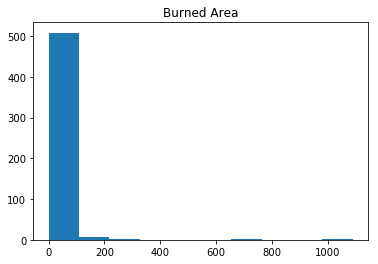

In [6]:
# histogram for area response variable:
plt.hist(forestfires.area)
plt.title("Burned Area")
plt.savefig('../results/AreaBeforeTransformation.png')

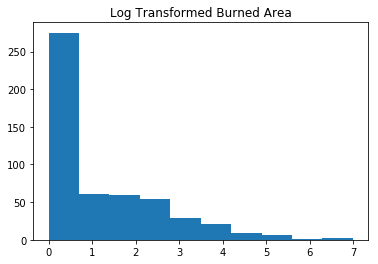

In [7]:
## after log transformation : 
plt.hist(np.log(forestfires.area+1))
plt.title("Log Transformed Burned Area")
plt.savefig('../results/AreaAfterTransformation.png')

 > As we can see from the histograms, log transformation helps the area variable to spread out. 

In [8]:
## Encode the categorical Variables :

# one way is: 
#le = LabelEncoder()
#forestfires["month"] = le.fit_transform(forestfires["month"])
#forestfires["day"] = le.fit_transform(forestfires["day"])


forestfires = pd.get_dummies(forestfires, prefix='m', columns=['month'])
forestfires = pd.get_dummies(forestfires, prefix='d', columns=['day'])

In [9]:
## after encoding: 
forestfires.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,m_nov,m_oct,m_sep,d_fri,d_mon,d_sat,d_sun,d_thu,d_tue,d_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,1,0,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,1,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
## X is perdictors' dataframe
## y is response' vector
X = forestfires.loc[:, forestfires.columns != "area"]
y = np.log(forestfires.area +1)

## save them into csv
X.to_csv("../results/X.csv", encoding='utf-8', index=False)
y.to_csv("../results/y.csv", encoding='utf-8', index=False)

In [11]:
## split the data: 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)

### Random Forest with all features:

In [12]:
randomforestscores = []

In [13]:
randf = RandomForestRegressor(max_depth=5)
randf.fit(X_train,y_train)
randomforestscores.append(randf.score(X_test,y_test))

### Lasso Regression (L1 Regularization): 

For alpha value of  0.0001
RMSE Training error: 1.32581403332
RMSE Validation error: 1.47423953797
Number of non-zero features 27
-------------------------------------------
For alpha value of  0.001
RMSE Training error: 1.32680200412
RMSE Validation error: 1.4533743819
Number of non-zero features 25
-------------------------------------------
For alpha value of  0.01
RMSE Training error: 1.34442253977
RMSE Validation error: 1.3981621192
Number of non-zero features 18
-------------------------------------------
For alpha value of  0.1
RMSE Training error: 1.37631711496
RMSE Validation error: 1.40485183101
Number of non-zero features 8
-------------------------------------------
For alpha value of  1
RMSE Training error: 1.38765527583
RMSE Validation error: 1.4052674921
Number of non-zero features 3
-------------------------------------------
For alpha value of  10
RMSE Training error: 1.39149771914
RMSE Validation error: 1.40836237248
Number of non-zero features 0
---------------------

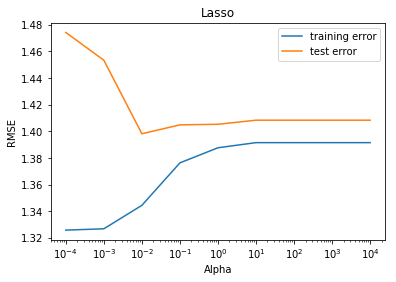

In [15]:
alpha_settings = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
Train_errorL = []
Valid_errorL = []
Nonzeros = []

for alp in alpha_settings:
    clfLasso = Lasso(alpha=alp)
    clfLasso.fit(X_train, y_train) 
    
    Train_errorL.append(np.sqrt(mean_squared_error(y_train, clfLasso.predict(X_train))))
    Valid_errorL.append(np.sqrt(mean_squared_error(y_test, clfLasso.predict(X_test))))
    #Train_error.append(1- clf.score(X,y))
    #Valid_error.append(1- clf.score(Xvalidate,yvalidate))
    print("For alpha value of ", alp)
    print("RMSE Training error:", np.sqrt(mean_squared_error(y_train, clfLasso.predict(X_train))))
    print("RMSE Validation error:", np.sqrt(mean_squared_error(y_test, clfLasso.predict(X_test))))
    print("Number of non-zero features",np.count_nonzero(clfLasso.coef_))
    Nonzeros.append(np.count_nonzero(clfLasso.coef_))
    print("-------------------------------------------")

plt.semilogx(alpha_settings, Train_errorL, label="training error")
plt.semilogx(alpha_settings, Valid_errorL, label="test error")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Alpha")
plt.title("Lasso")
plt.savefig('../results/LassoError.png')

print("---Optimal alpha for Lasso is",alpha_settings[np.argmin(Valid_errorL)])

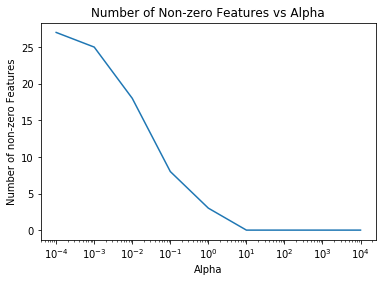

In [16]:
plt.figure()
plt.semilogx(alpha_settings,Nonzeros)
plt.title("Number of Non-zero Features vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Number of non-zero Features")

 > Lasso gives `alpha =0.01` as optimum value. So, let's choose alpha as 0.01 and select variables which are not zero with this value of alpha.

In [18]:
clfLasso = Lasso(alpha=0.01)
clfLasso.fit(X_train, y_train) 
np.count_nonzero(clfLasso.coef_)

18

In [19]:
# Lasso Selected Variables:
rfe = RFE(Lasso(alpha=0.01),n_features_to_select = 18 )
rfe.fit(X_train,y_train)
rfe.score(X_test,y_test)

0.014236574887041996

In [20]:
X.columns[rfe.support_]

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'm_dec',
       'm_feb', 'm_jun', 'm_mar', 'm_sep', 'd_fri', 'd_sat', 'd_thu', 'd_tue'],
      dtype='object')

In [21]:
Xlasso = X[(X.columns[rfe.support_])]
#save Xlasso into csv
Xlasso.to_csv("../results/Xlasso.csv", encoding='utf-8', index=False)

### ElasticNet Regression (L1+L2 Regularization): 

For alpha value of  0.0001
RMSE Training error: 1.32852981904
RMSE Validation error: 1.46517227674
Number of non-zero features 28
-----------------------
For alpha value of  0.001
RMSE Training error: 1.34089582112
RMSE Validation error: 1.43086081709
Number of non-zero features 26
-----------------------
For alpha value of  0.01
RMSE Training error: 1.38692234617
RMSE Validation error: 1.40371842361
Number of non-zero features 5
-----------------------
For alpha value of  0.1
RMSE Training error: 1.39149771914
RMSE Validation error: 1.40836237248
Number of non-zero features 0
-----------------------
For alpha value of  1
RMSE Training error: 1.39149771914
RMSE Validation error: 1.40836237248
Number of non-zero features 0
-----------------------
For alpha value of  10
RMSE Training error: 1.39149771914
RMSE Validation error: 1.40836237248
Number of non-zero features 0
-----------------------
For alpha value of  100
RMSE Training error: 1.39149771914
RMSE Validation error: 1.40836237248

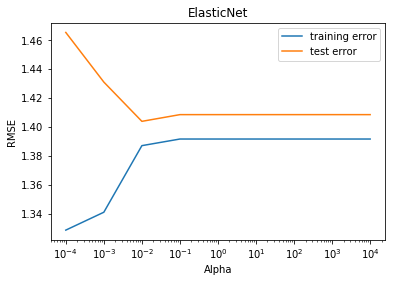

In [26]:
alpha_settings = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
Train_errorEN = []
Valid_errorEN = []
Nonzeros = []

for alp in alpha_settings:
    clfElasticNet = ElasticNet(alpha=alp,normalize =True)
    clfElasticNet.fit(X_train, y_train) 
    # mean_squared_err = lambda y, yhat: np.mean((y-yhat)**2)
    
    Train_errorEN.append(np.sqrt(mean_squared_error(y_train, clfElasticNet.predict(X_train))))
    Valid_errorEN.append(np.sqrt(mean_squared_error(y_test, clfElasticNet.predict(X_test))))
    #Train_error.append(1- clf.score(X,y))
    #Valid_error.append(1- clf.score(Xvalidate,yvalidate))
    print("For alpha value of ", alp)
    print("RMSE Training error:", np.sqrt(mean_squared_error(y_train, clfElasticNet.predict(X_train))))
    print("RMSE Validation error:", np.sqrt(mean_squared_error(y_test, clfElasticNet.predict(X_test))))
    print("Number of non-zero features",np.count_nonzero(clfElasticNet.coef_))
    Nonzeros.append(np.count_nonzero(clfElasticNet.coef_))
    print("-----------------------")

plt.semilogx(alpha_settings, Train_errorEN, label="training error")
plt.semilogx(alpha_settings, Valid_errorEN, label="test error")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Alpha")
plt.title("ElasticNet")
plt.savefig('../results/ElasticNetError.png')

print("---Optimal alpha for Elastic Net is",alpha_settings[np.argmin(Valid_errorEN)])

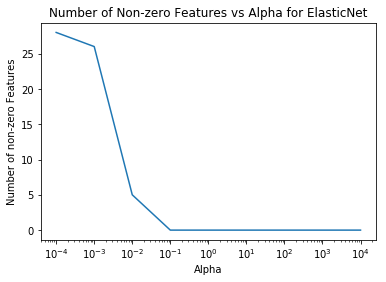

In [27]:
plt.figure()
plt.semilogx(alpha_settings,Nonzeros)
plt.title("Number of Non-zero Features vs Alpha for ElasticNet")
plt.xlabel("Alpha")
plt.ylabel("Number of non-zero Features")


In [28]:
clfElasticNet = ElasticNet(alpha=0.01)
clfElasticNet.fit(X_train, y_train) 
np.count_nonzero(clfElasticNet.coef_)

22

In [29]:
# ElasticNet Selected Variables:
rfe = RFE(ElasticNet(alpha=0.01), n_features_to_select=22)
rfe.fit(X_train,y_train)
rfe.score(X_test,y_test)

0.0070537447943211928

In [30]:
X.columns[rfe.support_]

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'm_dec', 'm_feb', 'm_jul', 'm_jun', 'm_mar', 'm_sep', 'd_fri', 'd_mon',
       'd_sat', 'd_thu', 'd_tue', 'd_wed'],
      dtype='object')

In [31]:
XelasticNet = X[(X.columns[rfe.support_])]
#save Xlasso into csv
XelasticNet.to_csv("../results/XElasticNet.csv", encoding='utf-8', index=False)


### Random Forest Regressions with only Selected Features from Lasso and ElasticNet

In [32]:
## for Lasso features:
X_train, X_test, y_train, y_test = train_test_split(Xlasso, y, test_size=0.33, random_state=19)

In [33]:
randf = RandomForestRegressor(max_depth=5)
randf.fit(X_train,y_train)
randomforestscores.append(randf.score(X_test,y_test))


In [34]:
## for ElasticNet features:

X_train, X_test, y_train, y_test = train_test_split(XelasticNet, y, test_size=0.33, random_state=19)

In [35]:
randf = RandomForestRegressor(max_depth=5)
randf.fit(X_train,y_train)
randomforestscores.append(randf.score(X_test,y_test))
randomforestscores = pd.DataFrame(randomforestscores)

In [36]:
randomforestscores = randomforestscores.rename(index={0: 'RandomForest with all features(29)'})
randomforestscores = randomforestscores.rename(index={1: 'RandomForest with Lasso features(18)'})
randomforestscores = randomforestscores.rename(index={2: 'RandomForest with ElasticNet features(22)'})
randomforestscores

,0
RandomForest with all features(29),-0.059792
RandomForest with Lasso features(18),-0.043251
RandomForest with ElasticNet features(22),-0.029118


In [38]:
pd.DataFrame(np.transpose(randomforestscores)).to_csv("../results/RandomForestScores.csv", encoding='utf-8', index=False)